<a href="https://colab.research.google.com/github/jcjimenezb123/PFM_PronosticoDemanda/blob/master/HoltWinters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
# dataframe opertations - pandas
import pandas as pd
# plotting data - matplotlib
from matplotlib import pyplot as plt
# time series - statsmodels 
# Seasonality decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import seasonal_decompose 
# holt winters 
# single exponential smoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing   
# double and triple exponential smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

(144, 1)
            Thousands of Passengers
Month                              
1949-01-01                      112
1949-02-01                      118
1949-03-01                      132
1949-04-01                      129
1949-05-01                      121


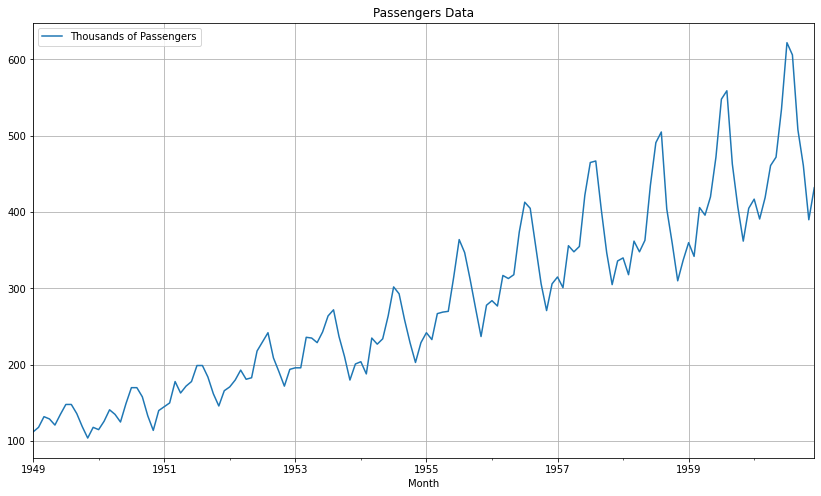

In [76]:
airline = pd.read_csv('airline_passengers.csv',index_col='Month', parse_dates=True)
# finding shape of the dataframe
print(airline.shape)
# having a look at the data
print(airline.head())
# plotting the original data
airline[['Thousands of Passengers']].plot(title='Passengers Data',figsize=(14,8),grid=True)

Descomposición de la serie temporal
---

Descomponemos la Serie temporal y buscaremos Niveles, Tendencias y Estacionalidad en los datos.

Podemos ver claramente que los datos tienen los 3, Niveles, Tendencias, Estacionalidad.

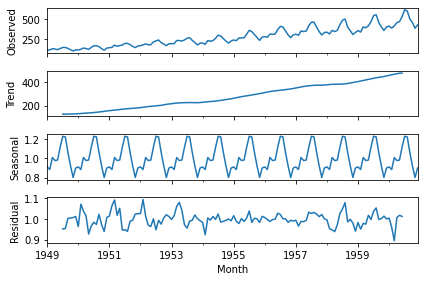

In [77]:
decompose_result = seasonal_decompose(airline['Thousands of Passengers'],model='multiplicative')
decompose_result.plot();

SMA - Simple Moving Averages
---

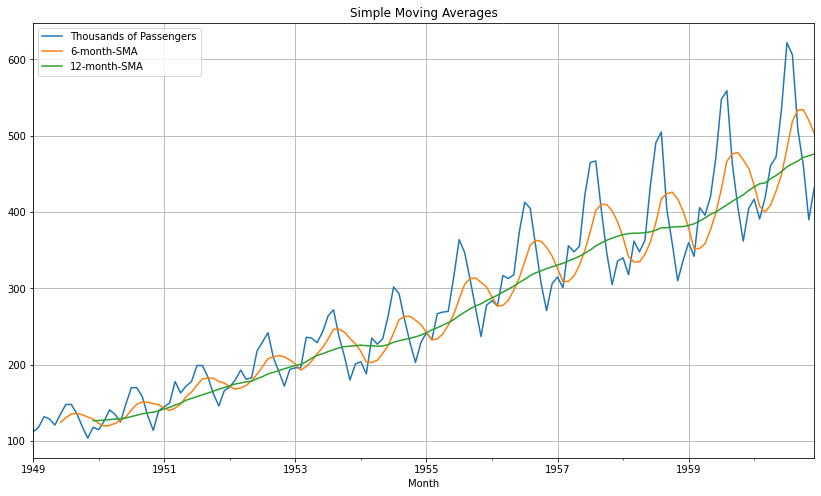

In [78]:
airline['6-month-SMA'] = airline['Thousands of Passengers'].rolling(window=6).mean()
airline['12-month-SMA'] = airline['Thousands of Passengers'].rolling(window=12).mean()
airline.plot(title='Simple Moving Averages',figsize=(14,8),grid=True);

EWMA - Exponentially Weighted Moving Average
---
EWMA alows to reduce the lag by putting more weight to the recent readings or values. The amount of weight applied is dependent on the actual parameters in the EWMA and the number of periods given in a window size

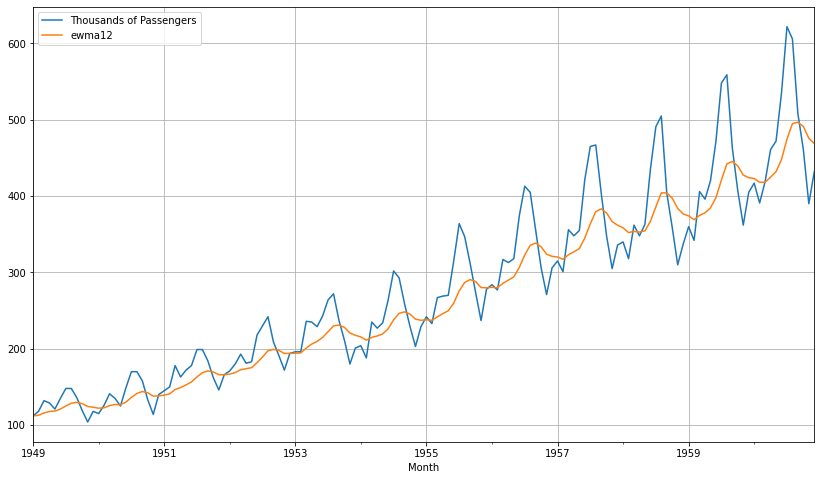

In [79]:
airline['ewma12'] = airline['Thousands of Passengers'].ewm(span=12,adjust=False).mean()
airline[['Thousands of Passengers','ewma12']].plot(figsize=(14,8),grid=True);

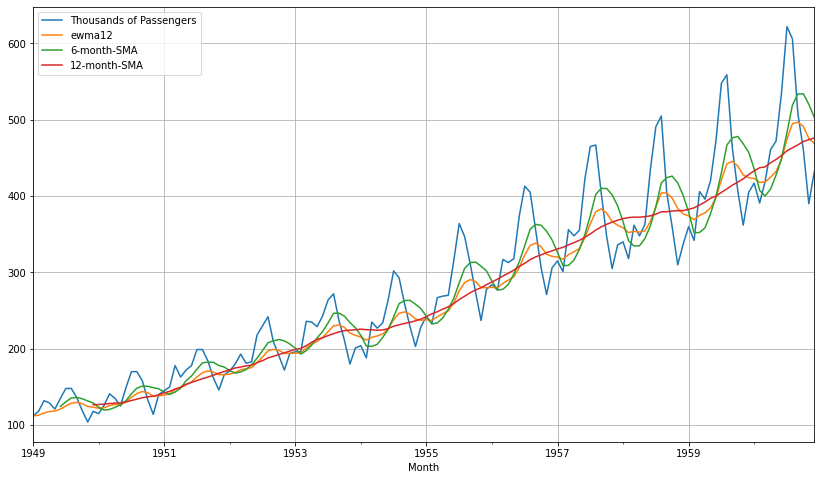

In [80]:
airline[['Thousands of Passengers','ewma12','6-month-SMA','12-month-SMA']].plot(figsize=(14,8),grid=True);

Ajuste de los datos con suavizado exponencial de Holt-Winters
---

Ahora ajustaremos estos datos en suavizado exponencial simple, doble y triple respectivamente, y veremos cómo funciona.
Antes de comenzar con los modelos, primero definiremos el coeficiente de ponderación Alfa y el Período de tiempo. También establecemos la frecuencia de DateTime a un nivel mensual.

In [43]:
# Establezca la frecuencia del índice de fecha y hora como Inicio mensual según lo indicado por la línea 
airline.index.freq = 'MS'
# Establezca el valor de Alpha y defina m (período de tiempo)
m = 12
alpha = 1/(2*m)

Ahora, ajustaremos los datos en el suavizado exponencial único,
HWES individual

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


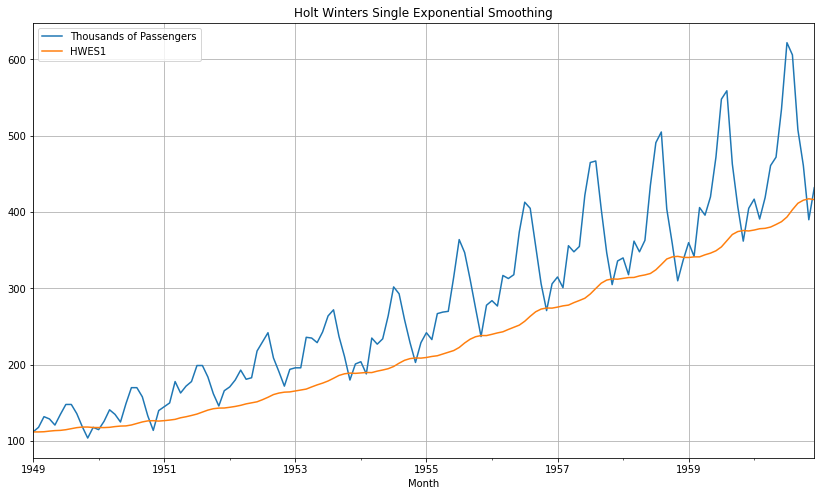

In [81]:
airline['HWES1'] = SimpleExpSmoothing(airline['Thousands of Passengers']).fit(smoothing_level=alpha,optimized=False,use_brute=True).fittedvalues
airline[['Thousands of Passengers','HWES1']].plot(title='Holt Winters Single Exponential Smoothing',figsize=(14,8),grid=True);

Como era de esperar, no encajó muy bien, y con razón, porque si recordamos, Single ES no funciona para datos con Tendencias y Estacionalidad.

HWES doble
---

Entonces, ajustaríamos los datos en Double ES, tanto en la tendencia aditiva como en la multiplicativa,

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


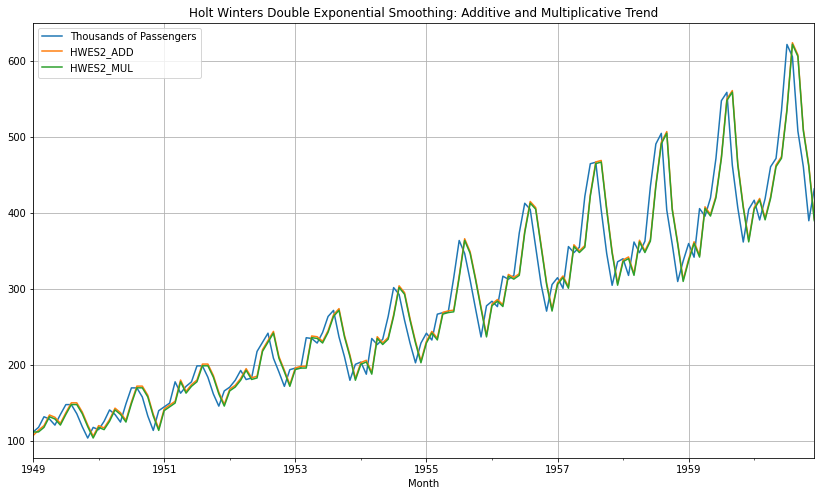

In [82]:
airline['HWES2_ADD'] = ExponentialSmoothing(airline['Thousands of Passengers'],trend='add').fit().fittedvalues
airline['HWES2_MUL'] = ExponentialSmoothing(airline['Thousands of Passengers'],trend='mul').fit().fittedvalues
airline[['Thousands of Passengers','HWES2_ADD','HWES2_MUL']].plot(title='Holt Winters Double Exponential Smoothing: Additive and Multiplicative Trend',
                                                                  figsize=(14,8),grid=True);

Bueno, esto se ve un poco mejor, pero como sabemos que existe la estacionalidad, pasaremos a Triple ES y veremos cómo encaja.

Triple HWES
---

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


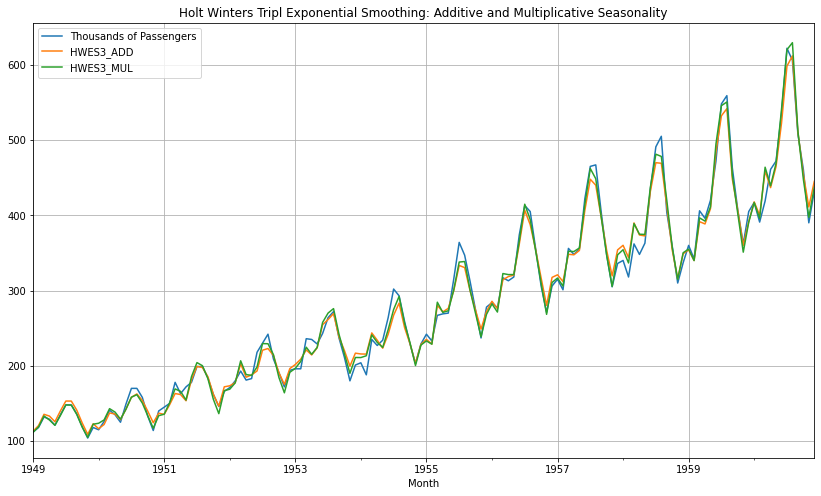

In [83]:
airline['HWES3_ADD'] = ExponentialSmoothing(airline['Thousands of Passengers'],trend='add',seasonal='add',seasonal_periods=12).fit().fittedvalues
airline['HWES3_MUL'] = ExponentialSmoothing(airline['Thousands of Passengers'],trend='mul',seasonal='mul',seasonal_periods=12).fit().fittedvalues
airline[['Thousands of Passengers','HWES3_ADD','HWES3_MUL']].plot(
    title='Holt Winters Tripl Exponential Smoothing: Additive and Multiplicative Seasonality',
    figsize=(14,8),grid=True);

¡Esto parece prometedor! Aquí hemos trazado la estacionalidad tanto aditiva como multiplicativa.
Pronóstico con suavizado exponencial de Holt-Winters (Triple ES)
Probemos y pronostiquemos secuencias, comencemos por dividir el conjunto de datos en Train y Test Set. Hemos tomado 120 puntos de datos como conjunto de trenes y los últimos 24 puntos de datos como conjunto de prueba.

¿qué estamos esperando? Ajustemos y pronostiquemos,


In [84]:
forecast_data = pd.read_csv('airline_passengers.csv',index_col='Month',parse_dates=True)
forecast_data.index.freq = 'MS'
# Split into train and test set
train_airline = forecast_data[:120]
test_airline = forecast_data[120:]

Text(0.5, 1.0, 'Train, Test and Predicted Test using Holt Winters')

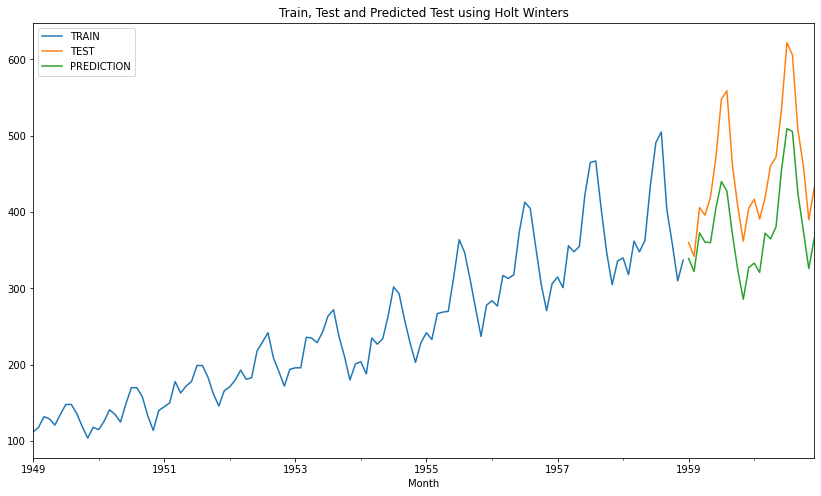

In [85]:
fitted_model = ExponentialSmoothing(train_airline['Thousands of Passengers'],trend='mul',seasonal='mul',seasonal_periods=24).fit()
test_predictions = fitted_model.forecast(24)

train_airline['Thousands of Passengers'].plot(legend=True,label='TRAIN',figsize=(14,8))
test_airline['Thousands of Passengers'].plot(legend=True,label='TEST',figsize=(14,8))
test_predictions.plot(legend=True,label='PREDICTION',figsize=(14,8))
plt.title('Train, Test and Predicted Test using Holt Winters')

A medida que nos acercamos al segmento previsto, parece que el modelo ha hecho un trabajo decente en general.

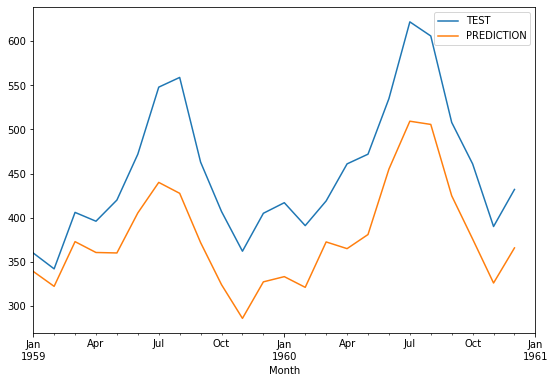

In [86]:
test_airline['Thousands of Passengers'].plot(legend=True,label='TEST',figsize=(9,6))
test_predictions.plot(legend=True,label='PREDICTION',xlim=['1959-01-01','1961-01-01'])

Métricas de evaluación
---
Veamos cómo le ha ido al modelo en términos de cálculos de términos de error. Utilizaríamos MAE (error absoluto medio) y MSE (error cuadrático medio) como métricas.

In [87]:
from sklearn.metrics import mean_absolute_error,mean_squared_error
print(f'Mean Absolute Error = {mean_absolute_error(test_airline,test_predictions)}')
print(f'Mean Squared Error = {mean_squared_error(test_airline,test_predictions)}')

Mean Absolute Error = 74.25461215485574
Mean Squared Error = 6273.679949696467
